# Finding fast growing firms 2025: Prediction and Classification

**Authors**: Elsa Andera Rodriguez, Petra Ilic

In [4]:
import os
import sys
import warnings
import pyfixest as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

import py_helper_functions as da


Import data (output from "firm_growth_data_prep")

In [5]:
data = pd.read_csv("data/clean/bisnode_firms_clean.csv")

In [6]:
# Calculate the 20th percentile
percentile_20 = data["sales_mil_log"].quantile(0.20)

# Create binary column: 0 if below 20th percentile, 1 if above
data["growth_binary"] = np.where(data["sales_mil_log"] <= percentile_20, 0, 1)

# Check the distribution
print(f"\nDistribution of binary column:")
print(data["growth_binary"].value_counts())


Distribution of binary column:
growth_binary
1    15228
0     3808
Name: count, dtype: int64


Define and create the binary variable.

Define helper functions

In [7]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    # Plot loss curve
    sns.lineplot(x=all_coords_copy["thresholds"], y=all_coords_copy["loss"])

    # Vertical line for optimal threshold
    plt.axvline(x=t, linestyle="--")

    # Annotations
    plt.text(
        t - 0.03,
        all_coords_copy["loss"].max() - 0.7,
        f"Best threshold: {round(t, 2)}",
        color=da.color[1],
        rotation=90,
        fontsize=8,
    )
    plt.text(t + 0.06, l, f"{round(l, 2)}", fontsize=8)

    # Labels and limits
    plt.xlabel("Thresholds")
    plt.ylabel("Expected loss")
    plt.xlim(-0.01, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Style
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linewidth=1)

    # Fill area under curve
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    # Plot ROC curve
    sns.lineplot(x=all_coords_copy["sp"], y=all_coords_copy["se"])

    # Highlight optimal threshold point
    plt.scatter(sp, se, color="black", s=10)
    plt.text(sp, se + 0.03, f"{round(sp, 2)}, {round(se, 2)}", fontsize=10, ha="center")

    # Fill area under curve
    plt.fill_between(
        all_coords_copy["sp"],
        all_coords_copy["se"],
        alpha=0.3,
        color="mediumaquamarine",
    )

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

Define variables

In [8]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "share_eq",
    "subscribed_cap",
]

In [9]:
#financial variables
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

In [10]:
#flag variables
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

In [11]:
#human capital related variables
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [12]:
#firms history related variables
firm = ["age", "age2", "new", "ind2_cat", "C(m_region_loc)", "C(urban_m)"]

In [13]:
M4 = (firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
)

# a) For Manufacturing 

In [14]:
data_manufacturing = data[data['ind2_cat'].isin([26, 27, 28, 29, 30])].copy()

## Part I: Probablitity prediction

Split data to train and test.

In [15]:
data_train, data_holdout = train_test_split(data_manufacturing, train_size=0.8, random_state=42)

In [16]:
print("Total")
print(data_manufacturing["growth_binary"].value_counts(normalize=True))
print("Train")
print(data_train["growth_binary"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["growth_binary"].value_counts(normalize=True))


Total
growth_binary
1    0.866227
0    0.133773
Name: proportion, dtype: float64
Train
growth_binary
1    0.863127
0    0.136873
Name: proportion, dtype: float64
Holdout
growth_binary
1    0.878628
0    0.121372
Name: proportion, dtype: float64


### Models

In [17]:
# specify 5 fold cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

Logit M4

In [18]:
# set up x variables
logit_model_vars = [M4]

In [19]:
# set up logit model object
C_value_logit = [1e20]

In [20]:
logit_models = dict()
CV_RMSE_folds = dict()

# M4 formula
model_equation = "growth_binary ~ " + " + ".join(M4)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

# Fit
LRCV_brier = LogisticRegressionCV(
    Cs=C_value_logit,
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="newton-cg",
    tol=1e-7,
    random_state=42,
)

best_logit = LRCV_brier.fit(X_train, y_train)

# CV RMSE per fold
CV_RMSE_folds = np.sqrt(-1 * best_logit.scores_[1].ravel())


modified this code from task 1, to consider only M4

In [21]:
pd.DataFrame(CV_RMSE_folds)

,0
0,0.264905
1,0.249007
2,0.267705
3,0.291774
4,0.252080


### Performance

AUC, Calibration Curve, Confusion Matrix, ROC

In [22]:
# AUC for M4 folds
model_equation = "growth_binary ~ " + " + ".join(M4)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

LRCV_auc = LogisticRegressionCV(
    Cs=C_value_logit,
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="newton-cg",
    tol=1e-7,
    random_state=42,
)

best_logit_auc = LRCV_auc.fit(X_train, y_train)

CV_AUC_folds = best_logit_auc.scores_[1].ravel()

Put a summary frame together

In [23]:
summary = pd.DataFrame({
    "Number of Coefficients": [best_logit.n_features_in_],
    "CV RMSE": [CV_RMSE_folds.mean()],
    "CV AUC": [CV_AUC_folds.mean()],
}, index=["M4"])

summary

,Number of Coefficients,CV RMSE,CV AUC
M4,68,0.265094,0.926949


In [24]:

model_equation = "growth_binary~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)


In [25]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["growth_binary"]), 3)

np.float64(0.249)

calibration curve

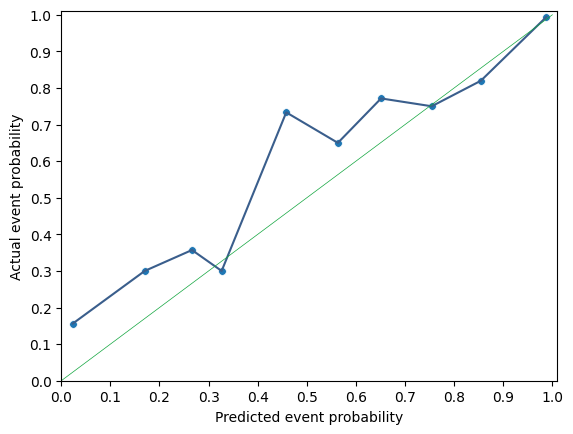

In [26]:
da.create_calibration_plot(
    data_holdout,
    prob_var="best_logit_pred_proba",
    actual_var="growth_binary",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

In [27]:
#confusion table
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (growth_binary less than 20%): ", counts[0])
print(values[1], " (growth_binary above 20%): ", counts[1])

0.0  (growth_binary less than 20%):  81
1.0  (growth_binary above 20%):  677


In [28]:
cm_object1 = confusion_matrix(
    data_holdout["growth_binary"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,54,38
Actual growth_binary,27,639


In [29]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1b

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,54,38
Actual growth_binary,27,639


In [30]:
mean_predicted_growth_binary_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_growth_binary_prob, 3)

np.float64(0.855)

In [31]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_growth_binary_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm2

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,84,8
Actual growth_binary,117,549


visualize roc (comparing multuple thresholds)

In [32]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["growth_binary"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [33]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

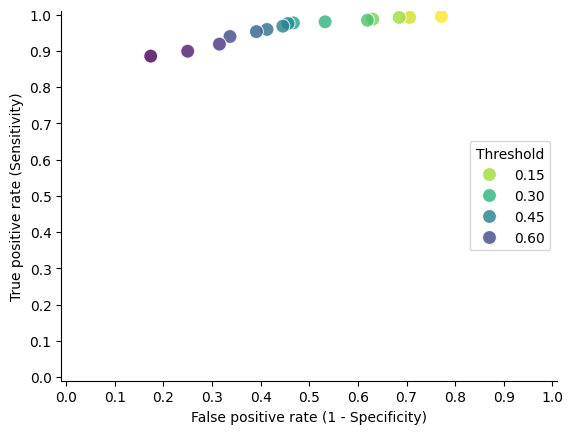

In [34]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

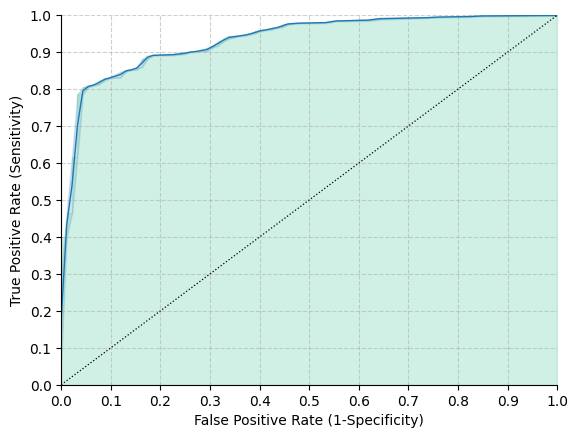

In [35]:
create_roc_plot(data_holdout["growth_binary"], data_holdout["best_logit_pred_proba"])

## Part II: Classification

Define the loss function.

In [36]:
FP = 10
FN = 1
cost = FN / FP

In [37]:
prevelance = y_train.sum() / len(y_train)

Look for the optimal classification threshold and calculate expected loss.

In [38]:
# --- M4 threshold optimization across CV folds ---
model_equation = "growth_binary ~ " + " + ".join(M4)
_, X_cv = patsy.dmatrices(model_equation, data_train)
X_cv = pd.DataFrame(X_cv)

best_thresholds = []
expected_loss = []

fold = 0
for train_index, test_index in k.split(X_cv):
    X_fold = X_cv.iloc[test_index, :]
    y_fold = data_train["growth_binary"].iloc[test_index]
    pred_fold = generate_fold_prediction(best_logit, X_fold, fold, 0)
    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
    
    optimal_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                thresholds,
            )
        ),
        key=lambda i: i[0],
        reverse=True,
    )[0][1]
    
    best_thresholds.append(optimal_threshold)
    threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

best_threshold_cv = np.mean(best_thresholds)
expected_loss_cv = np.mean(expected_loss)

# Fold 5 results
fold5_threshold = optimal_threshold
fold5_expected_loss = curr_exp_loss

fold5_all_coords = pd.DataFrame({
    "false_pos": false_pos_rate * sum(y_fold == 0),
    "true_pos": true_pos_rate * sum(y_fold == 1),
    "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
    "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
    "pos": sum(y_fold == 1),
    "neg": sum(y_fold == 0),
    "n": len(y_fold),
    "thresholds": thresholds,
})

print(f"M4 - Best CV threshold: {round(best_threshold_cv, 4)}")
print(f"M4 - Expected CV loss: {round(expected_loss_cv, 4)}")

M4 - Best CV threshold: 0.9203
M4 - Expected CV loss: 0.2593


In [39]:
summary_with_lossfnc = pd.DataFrame({
    "Model": ["M4"],
    "Avg of optimal thresholds": [best_threshold_cv],
    "Threshold for Fold5": [fold5_threshold],
    "Avg expected loss": [expected_loss_cv],
    "Expected loss for Fold5": [fold5_expected_loss],
})

summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M4,0.920289,0.928464,0.259256,0.293729


**Best Model**: M4 has the smallest average expected loss.

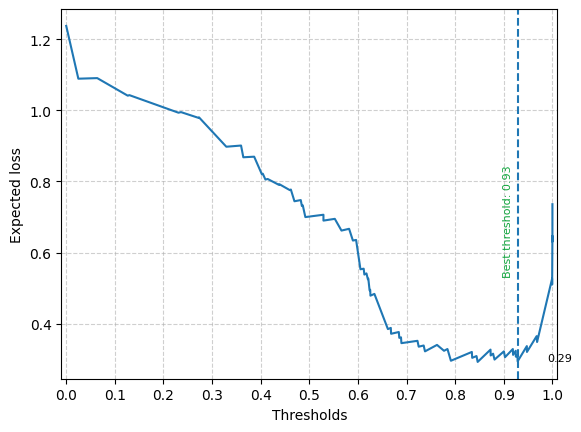

In [40]:
create_loss_plot(
    fold5_all_coords,
    fold5_threshold,
    fold5_expected_loss,
)

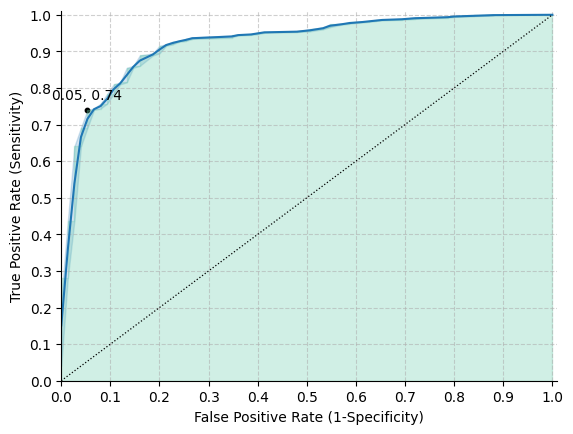

In [41]:
create_roc_plot_with_optimal(
    fold5_all_coords, fold5_threshold
)

In [42]:
CV_RMSE_folds_mfg = CV_RMSE_folds.copy()
CV_AUC_folds_mfg = CV_AUC_folds.copy()
best_threshold_cv_mfg = best_threshold_cv
expected_loss_cv_mfg = expected_loss_cv
data_holdout_mfg = data_holdout.copy()

# b) For Services 

In [43]:
data_services = data[data['ind2_cat'].isin([33, 55, 56])].copy()

## Part I: Probablitity prediction

Split data to train and test.

In [44]:
data_train, data_holdout = train_test_split(data_services, train_size=0.8, random_state=42)

In [45]:
print("Total")
print(data_services["growth_binary"].value_counts(normalize=True))
print("Train")
print(data_train["growth_binary"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["growth_binary"].value_counts(normalize=True))


Total
growth_binary
1    0.783484
0    0.216516
Name: proportion, dtype: float64
Train
growth_binary
1    0.785339
0    0.214661
Name: proportion, dtype: float64
Holdout
growth_binary
1    0.776066
0    0.223934
Name: proportion, dtype: float64


### Models

In [46]:
# specify 5 fold cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

Logit M4

In [47]:
# set up x variables
logit_model_vars = [M4]

In [48]:
# set up logit model object
C_value_logit = [1e20]

In [49]:
logit_models = dict()
CV_RMSE_folds = dict()

# M4 formula
model_equation = "growth_binary ~ " + " + ".join(M4)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

# Fit
LRCV_brier = LogisticRegressionCV(
    Cs=C_value_logit,
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="newton-cg",
    tol=1e-7,
    random_state=42,
)

best_logit = LRCV_brier.fit(X_train, y_train)

# CV RMSE per fold
CV_RMSE_folds = np.sqrt(-1 * best_logit.scores_[1].ravel())


modified this code from task 1, to consider only M4

In [50]:
pd.DataFrame(CV_RMSE_folds)

,0
0,0.303132
1,0.304979
2,0.304110
3,0.308425
4,0.312751


### Performance

AUC, Calibration Curve, Confusion Matrix, ROC

In [51]:
# AUC for M4 folds
model_equation = "growth_binary ~ " + " + ".join(M4)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

LRCV_auc = LogisticRegressionCV(
    Cs=C_value_logit,
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="newton-cg",
    tol=1e-7,
    random_state=42,
)

best_logit_auc = LRCV_auc.fit(X_train, y_train)

CV_AUC_folds = best_logit_auc.scores_[1].ravel()

Put a summary frame together

In [52]:
summary = pd.DataFrame({
    "Number of Coefficients": [best_logit.n_features_in_],
    "CV RMSE": [CV_RMSE_folds.mean()],
    "CV AUC": [CV_AUC_folds.mean()],
}, index=["M4"])

summary

,Number of Coefficients,CV RMSE,CV AUC
M4,68,0.306679,0.911487


In [53]:

model_equation = "growth_binary~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)


In [54]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["growth_binary"]), 3)

np.float64(0.298)

calibration curve

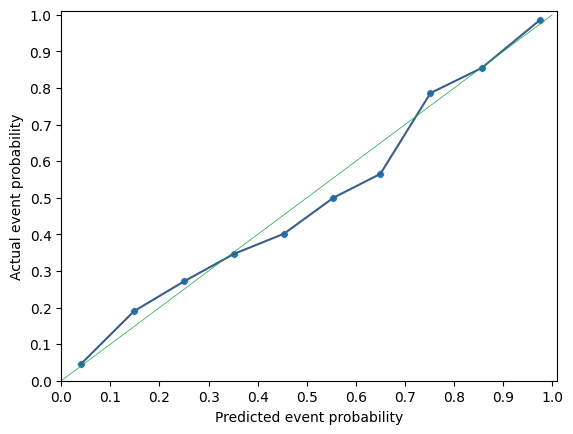

In [55]:
da.create_calibration_plot(
    data_holdout,
    prob_var="best_logit_pred_proba",
    actual_var="growth_binary",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

In [56]:
#confusion table
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (growth_binary less than 20%): ", counts[0])
print(values[1], " (growth_binary above 20%): ", counts[1])

0.0  (growth_binary less than 20%):  539
1.0  (growth_binary above 20%):  2511


In [57]:
cm_object1 = confusion_matrix(
    data_holdout["growth_binary"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,416,267
Actual growth_binary,123,2244


In [58]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm1b

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,416,267
Actual growth_binary,123,2244


In [59]:
mean_predicted_growth_binary_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_growth_binary_prob, 3)

np.float64(0.775)

In [60]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_growth_binary_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["growth_binary"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no growth_binary", "Actual growth_binary"],
    columns=["Predicted no growth_binary", "Predicted growth_binary"],
)
cm2

,Predicted no growth_binary,Predicted growth_binary
Actul no growth_binary,589,94
Actual growth_binary,410,1957


In [61]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["growth_binary"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [62]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

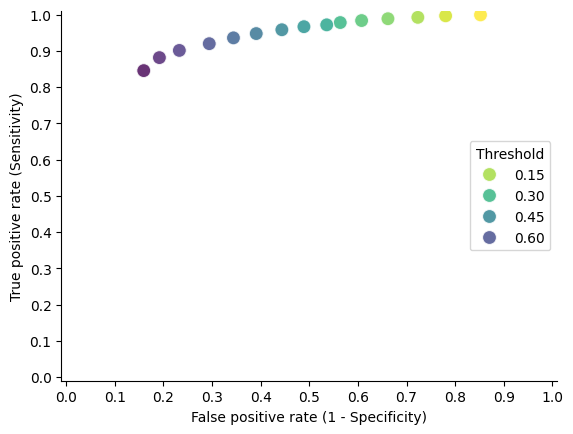

In [63]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

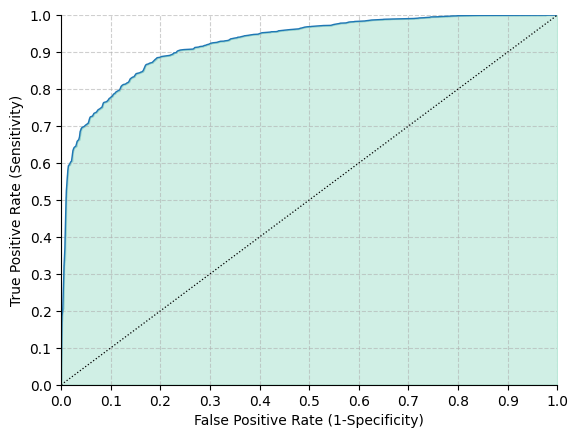

In [64]:
create_roc_plot(data_holdout["growth_binary"], data_holdout["best_logit_pred_proba"])

## Part II: Classification

No need to re-define the loss function, as it is only one and has ben defined above. 

In [65]:
prevelance = y_train.sum() / len(y_train)

In [66]:
# --- M4 threshold optimization across CV folds ---
model_equation = "growth_binary ~ " + " + ".join(M4)
_, X_cv = patsy.dmatrices(model_equation, data_train)
X_cv = pd.DataFrame(X_cv)

best_thresholds = []
expected_loss = []

fold = 0
for train_index, test_index in k.split(X_cv):
    X_fold = X_cv.iloc[test_index, :]
    y_fold = data_train["growth_binary"].iloc[test_index]
    pred_fold = generate_fold_prediction(best_logit, X_fold, fold, 0)
    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
    
    optimal_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                thresholds,
            )
        ),
        key=lambda i: i[0],
        reverse=True,
    )[0][1]
    
    best_thresholds.append(optimal_threshold)
    threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)
    fold += 1

best_threshold_cv = np.mean(best_thresholds)
expected_loss_cv = np.mean(expected_loss)

# Fold 5 results
fold5_threshold = optimal_threshold
fold5_expected_loss = curr_exp_loss

fold5_all_coords = pd.DataFrame({
    "false_pos": false_pos_rate * sum(y_fold == 0),
    "true_pos": true_pos_rate * sum(y_fold == 1),
    "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
    "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
    "pos": sum(y_fold == 1),
    "neg": sum(y_fold == 0),
    "n": len(y_fold),
    "thresholds": thresholds,
})

print(f"M4 - Best CV threshold: {round(best_threshold_cv, 4)}")
print(f"M4 - Expected CV loss: {round(expected_loss_cv, 4)}")

M4 - Best CV threshold: 0.891
M4 - Expected CV loss: 0.3702


In [67]:
summary_with_lossfnc = pd.DataFrame({
    "Model": ["M4"],
    "Avg of optimal thresholds": [best_threshold_cv],
    "Threshold for Fold5": [fold5_threshold],
    "Avg expected loss": [expected_loss_cv],
    "Expected loss for Fold5": [fold5_expected_loss],
})

summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M4,0.890981,0.864279,0.370204,0.393194


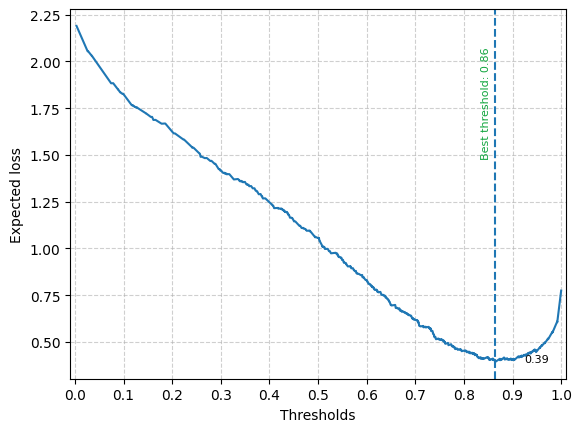

In [68]:
create_loss_plot(
    fold5_all_coords,
    fold5_threshold,
    fold5_expected_loss,
)

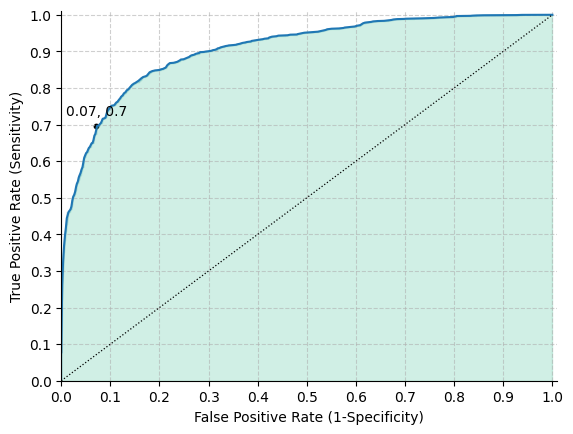

In [69]:
create_roc_plot_with_optimal(
    fold5_all_coords, fold5_threshold
)

In [70]:
CV_RMSE_folds_svc = CV_RMSE_folds.copy()
CV_AUC_folds_svc = CV_AUC_folds.copy()
best_threshold_cv_svc = best_threshold_cv
expected_loss_cv_svc = expected_loss_cv
data_holdout_svc = data_holdout.copy()

# Comparison

In [71]:
comparison = pd.DataFrame({
    "Manufacturing": {
        "N observations": len(data_manufacturing),
        "CV RMSE": CV_RMSE_folds_mfg.mean(),    
        "CV AUC": CV_AUC_folds_mfg.mean(),
        "Holdout RMSE": round(rmse(data_holdout_mfg["best_logit_pred_proba"], data_holdout_mfg["growth_binary"]), 4),
        "Best threshold": best_threshold_cv_mfg,
        "Expected loss": expected_loss_cv_mfg,
    },
    "Services": {
        "N observations": len(data_services),
        "CV RMSE": CV_RMSE_folds_svc.mean(),
        "CV AUC": CV_AUC_folds_svc.mean(),
        "Holdout RMSE": round(rmse(data_holdout_svc["best_logit_pred_proba"], data_holdout_svc["growth_binary"]), 4),
        "Best threshold": best_threshold_cv_svc,
        "Expected loss": expected_loss_cv_svc,
    }
})

comparison

,Manufacturing,Services
N observations,3790.000000,15246.000000
CV RMSE,0.265094,0.306679
CV AUC,0.926949,0.911487
Holdout RMSE,0.248700,0.298000
Best threshold,0.920289,0.890981
Expected loss,0.259256,0.370204


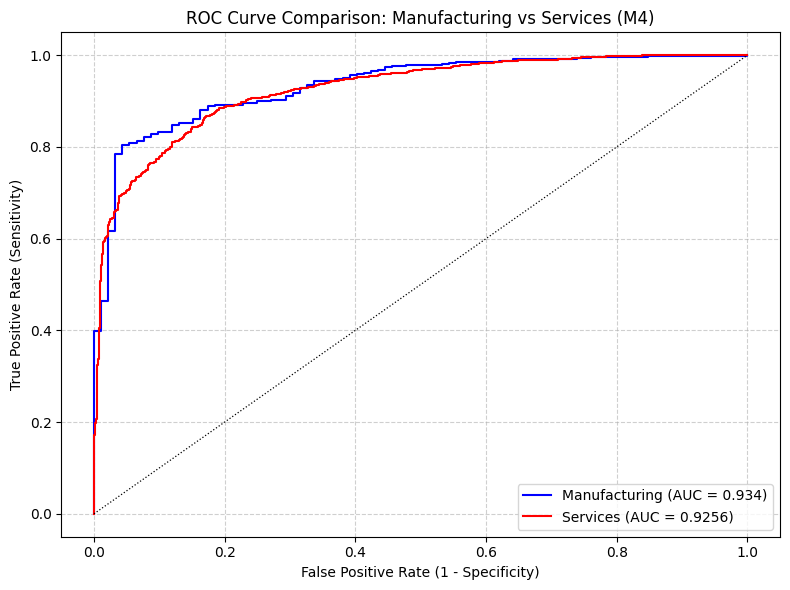

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))

fpr_mfg, tpr_mfg, _ = roc_curve(data_holdout_mfg["growth_binary"], data_holdout_mfg["best_logit_pred_proba"])
fpr_svc, tpr_svc, _ = roc_curve(data_holdout_svc["growth_binary"], data_holdout_svc["best_logit_pred_proba"])

auc_mfg = round(roc_auc_score(data_holdout_mfg["growth_binary"], data_holdout_mfg["best_logit_pred_proba"]), 4)
auc_svc = round(roc_auc_score(data_holdout_svc["growth_binary"], data_holdout_svc["best_logit_pred_proba"]), 4)

ax.plot(fpr_mfg, tpr_mfg, label=f"Manufacturing (AUC = {auc_mfg})", color="blue")
ax.plot(fpr_svc, tpr_svc, label=f"Services (AUC = {auc_svc})", color="red")
ax.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity)")
ax.set_title("ROC Curve Comparison: Manufacturing vs Services (M4)")
ax.legend(loc="lower right")
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

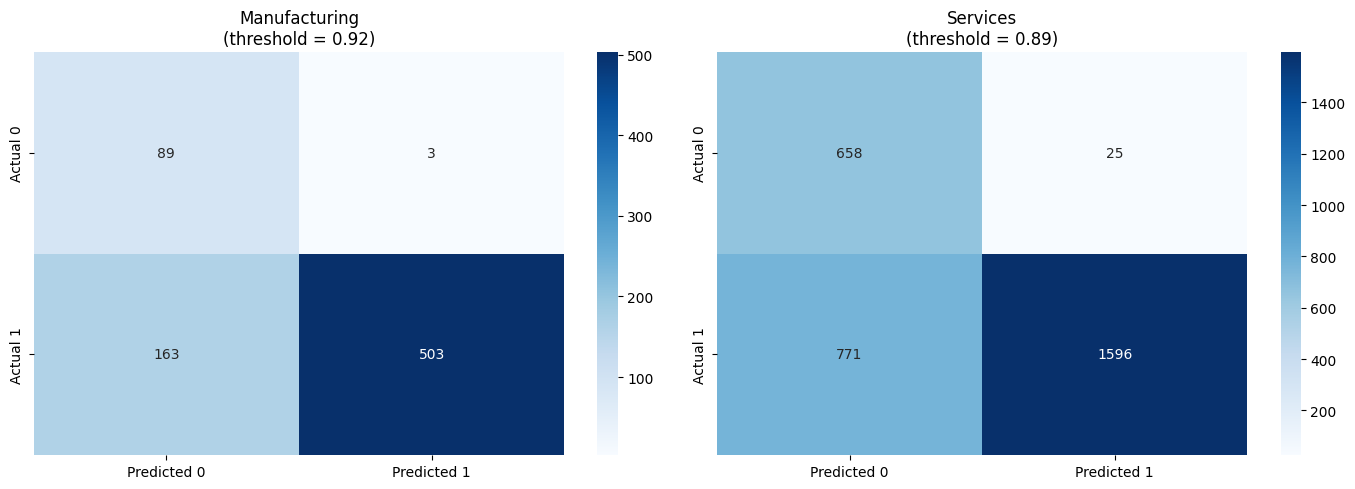

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, data_ho, label, threshold in zip(
    axes,
    [data_holdout_mfg, data_holdout_svc],
    ["Manufacturing", "Services"],
    [best_threshold_cv_mfg, best_threshold_cv_svc]
):
    y_pred = np.where(data_ho["best_logit_pred_proba"] < threshold, 0, 1)
    cm = confusion_matrix(data_ho["growth_binary"], y_pred, labels=[0, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    ax.set_title(f"{label}\n(threshold = {round(threshold, 2)})")

plt.tight_layout()
plt.show()